# Individual Assignment II
GitHub Repo: https://github.com/singhreyn/ML-fundamentals-2025

#### Task 1: Exploratory Data Analysis (EDA)

In [35]:
import pandas as pd

# Load the hour.csv dataset
df = pd.read_csv("hour.csv")
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


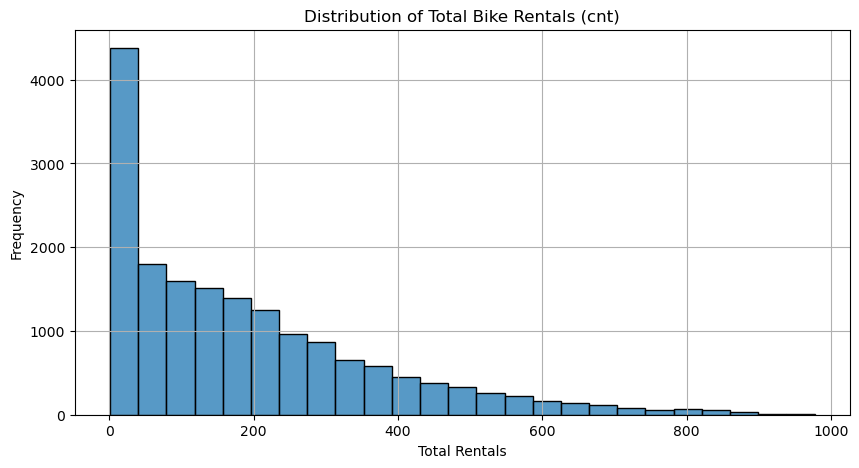

Skewness of cnt: 1.2774116037490577


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df['cnt'], bins=25)
plt.title("Distribution of Total Bike Rentals (cnt)")
plt.xlabel("Total Rentals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print("Skewness of cnt:", df['cnt'].skew())

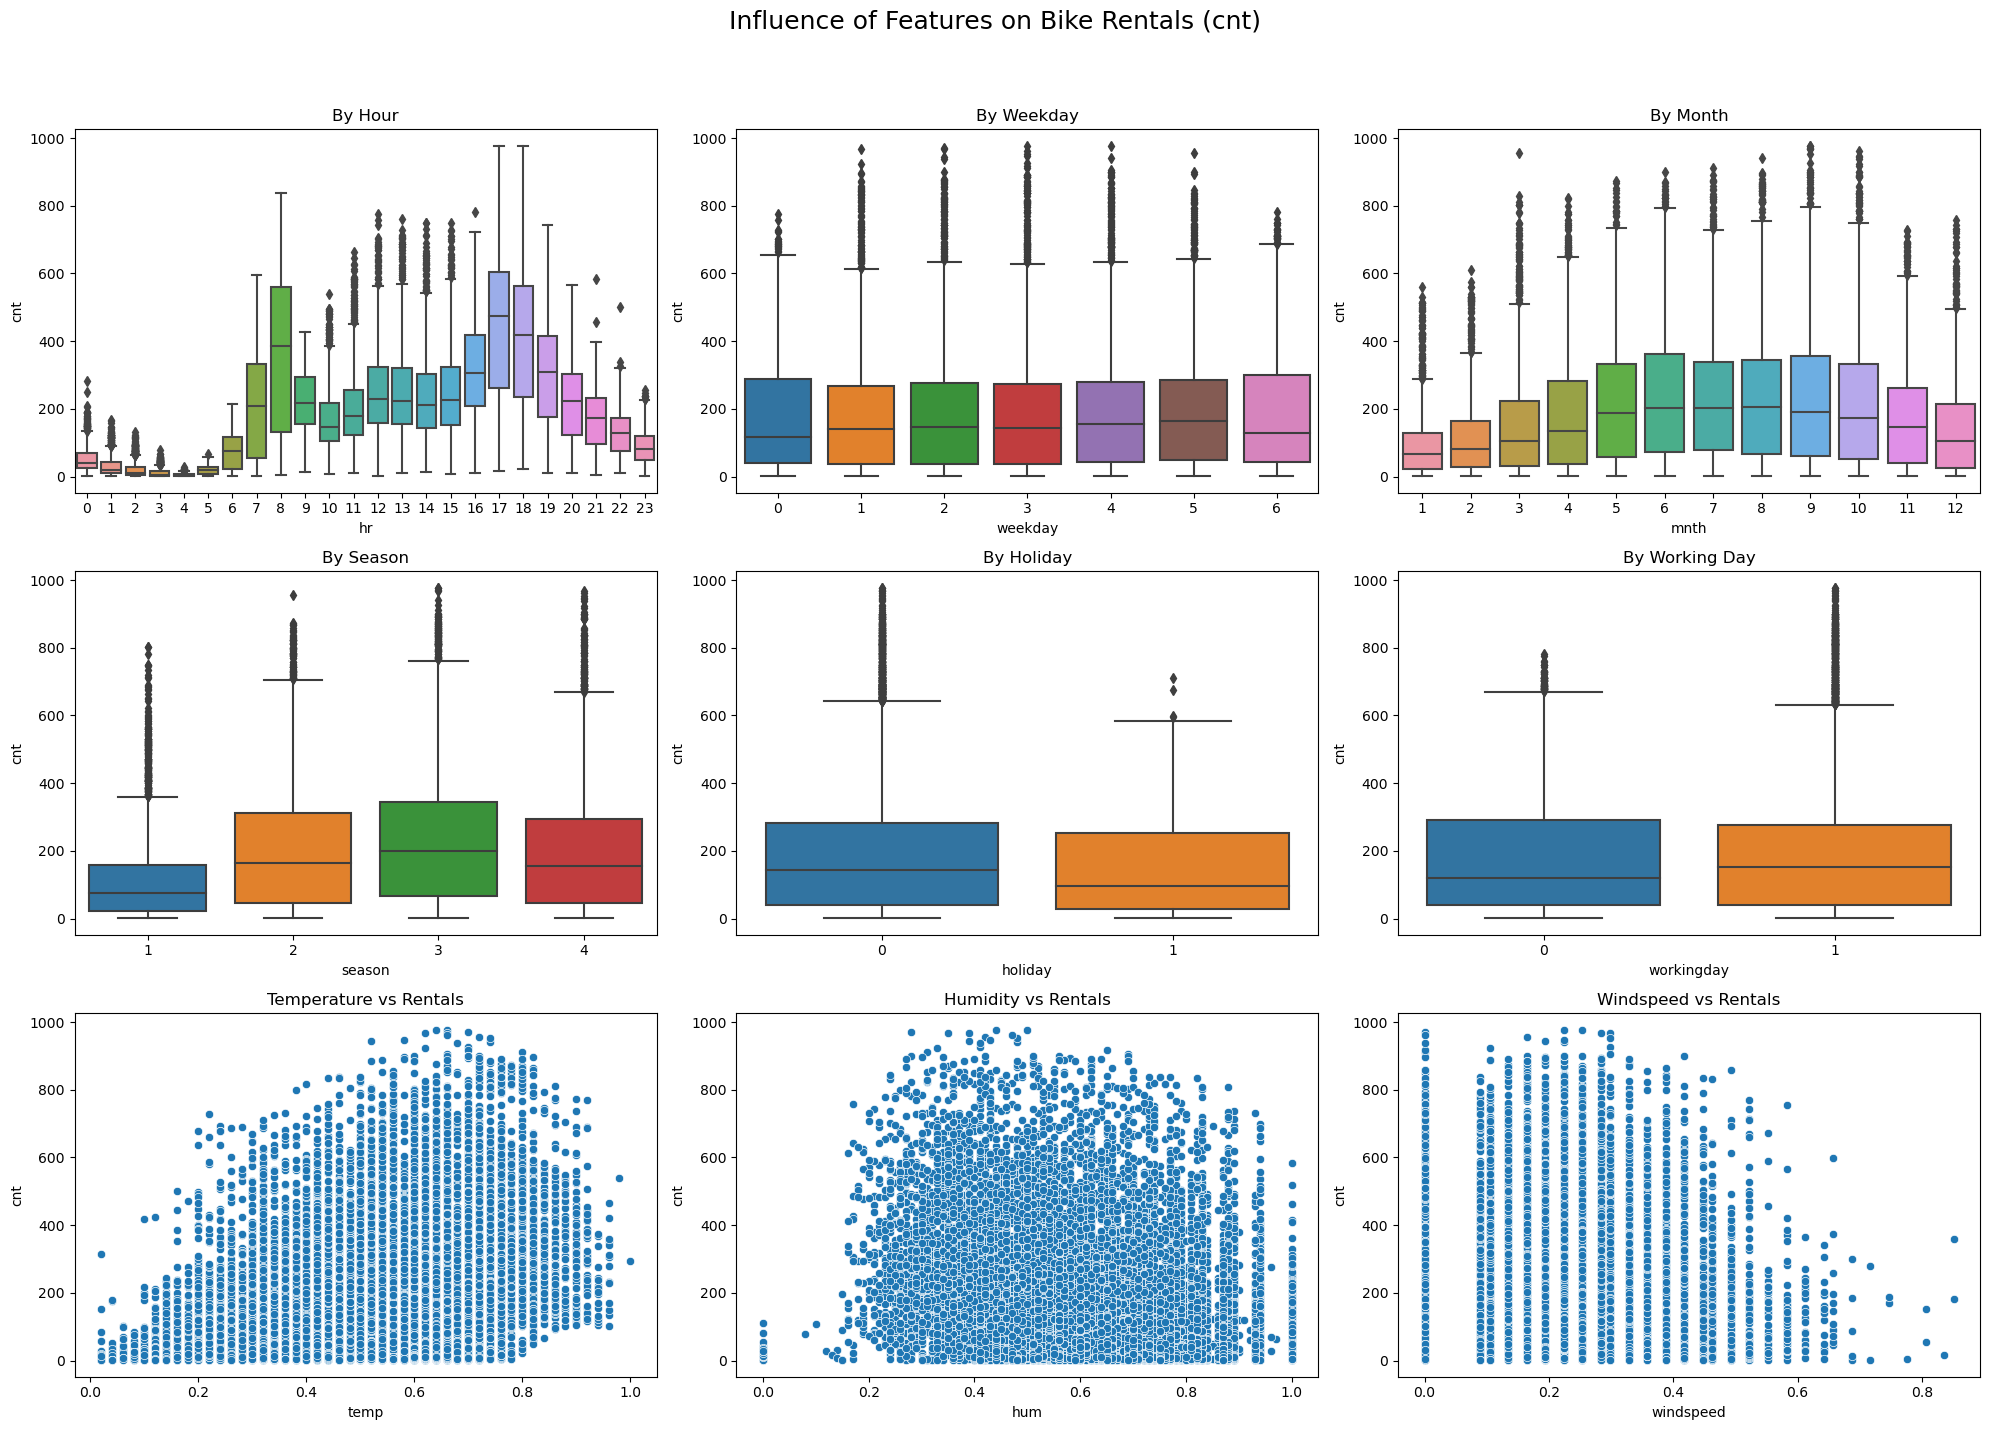

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Influence of Features on Bike Rentals (cnt)', fontsize=18)

# Row 1: Temporal
sns.boxplot(x='hr', y='cnt', data=df, ax=axes[0, 0])
axes[0, 0].set_title('By Hour')

sns.boxplot(x='weekday', y='cnt', data=df, ax=axes[0, 1])
axes[0, 1].set_title('By Weekday')

sns.boxplot(x='mnth', y='cnt', data=df, ax=axes[0, 2])
axes[0, 2].set_title('By Month')

# Row 2: Categorical/Binary
sns.boxplot(x='season', y='cnt', data=df, ax=axes[1, 0])
axes[1, 0].set_title('By Season')

sns.boxplot(x='holiday', y='cnt', data=df, ax=axes[1, 1])
axes[1, 1].set_title('By Holiday')

sns.boxplot(x='workingday', y='cnt', data=df, ax=axes[1, 2])
axes[1, 2].set_title('By Working Day')

# Row 3: Continuous Features
sns.scatterplot(x='temp', y='cnt', data=df, ax=axes[2, 0])
axes[2, 0].set_title('Temperature vs Rentals')

sns.scatterplot(x='hum', y='cnt', data=df, ax=axes[2, 1])
axes[2, 1].set_title('Humidity vs Rentals')

sns.scatterplot(x='windspeed', y='cnt', data=df, ax=axes[2, 2])
axes[2, 2].set_title('Windspeed vs Rentals')

# Format everything nicely
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [38]:
df.drop(columns=['instant', 'dteday', 'casual', 'registered'], inplace=True)

#### Task 2: Data Splitting

In [39]:
from sklearn.model_selection import train_test_split

# 1. Separate features and target
X = df.drop(columns=['cnt'])   # features only
y = df['cnt']                  # target

# 2. Split into 60% training and 40% temp (to later split equally into val/test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# 3. Split temp into 50% validation, 50% test (i.e. 20% each of original data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 4. Print sizes
print(f"Training set:     {X_train.shape[0]} rows")
print(f"Validation set:   {X_val.shape[0]} rows")
print(f"Test set:         {X_test.shape[0]} rows")

Training set:     10427 rows
Validation set:   3476 rows
Test set:         3476 rows


#### Task 3: Feature Engineering

In [40]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Features to be processed
cyclical_features = ['hr', 'weekday']
categorical_features = ['season', 'mnth', 'weathersit']
continuous_features = ['temp', 'atemp', 'hum', 'windspeed']

# Helper function to encode cyclical features
def encode_cyclical(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df.drop(columns=[col])

# Apply cyclical encoding
for col, max_val in zip(cyclical_features, [24, 7]):
    X_train = encode_cyclical(X_train, col, max_val)
    X_val = encode_cyclical(X_val, col, max_val)
    X_test = encode_cyclical(X_test, col, max_val)

# One-hot encode categorical variables (fit on training only)
X_train = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
X_val = pd.get_dummies(X_val, columns=categorical_features, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)

# Align val/test to training (in case some categories are missing)
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Scale continuous features
scaler = StandardScaler()
X_train[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_val[continuous_features] = scaler.transform(X_val[continuous_features])
X_test[continuous_features] = scaler.transform(X_test[continuous_features])

# Check the shape after preprocessing
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (10427, 28)
Validation set shape: (3476, 28)
Test set shape: (3476, 28)


#### Task 4: Baseline Model – Linear Regression

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Initialize and train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred = lr_model.predict(X_val)

# Evaluation metrics
mse = mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"Linear Regression Validation MSE: {mse:.2f}")
print(f"Linear Regression Validation MAE: {mae:.2f}")
print(f"Linear Regression Validation R² Score: {r2:.4f}")

Linear Regression Validation MSE: 15772.30
Linear Regression Validation MAE: 91.89
Linear Regression Validation R² Score: 0.5147


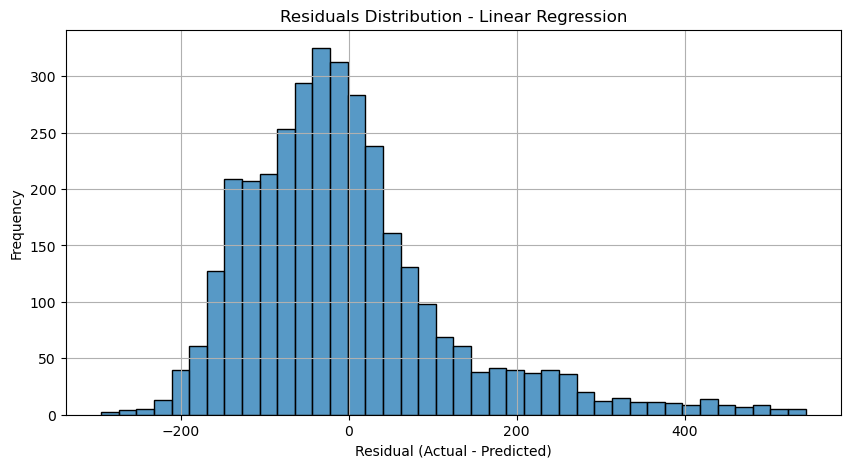

In [42]:
# Residuals = actual - predicted
residuals = y_val - y_val_pred

# Plot distribution of residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=40)
plt.title("Residuals Distribution - Linear Regression")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

#### Task 5: Random Forest Regressor - Model Specification and Training

In [45]:
from sklearn.ensemble import RandomForestRegressor

# Train the model with default params: 100 trees, no max depth
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict on validation set
y_pred_rf = rf_model.predict(X_val)

# Evaluate the model
mse_rf = mean_squared_error(y_val, y_pred_rf)
mae_rf = mean_absolute_error(y_val, y_pred_rf)
r2_rf = r2_score(y_val, y_pred_rf)

# Print results
print("Random Forest Regressor Evaluation:")
print(f"  MSE : {mse_rf:.2f}")
print(f"  MAE : {mae_rf:.2f}")
print(f"  R²  : {r2_rf:.4f}")

Random Forest Regressor Evaluation:
  MSE : 1790.57
  MAE : 25.79
  R²  : 0.9449


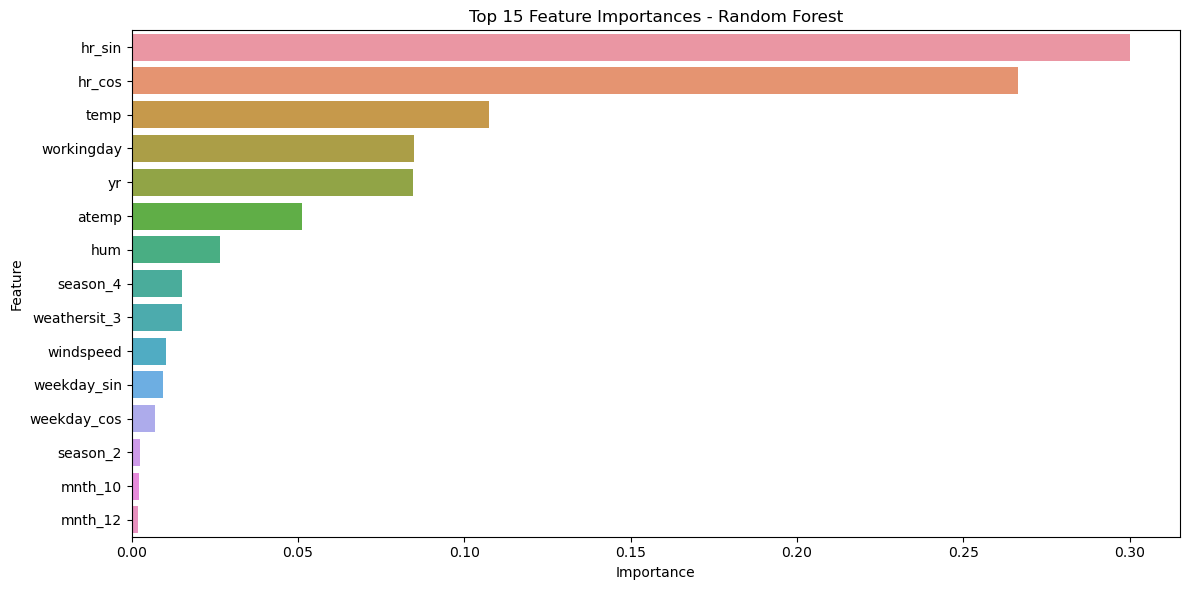

In [49]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X_train.columns
sorted_idx = np.argsort(importances)[::-1]

# Plot Top 15
plt.figure(figsize=(12, 6))
sns.barplot(x=importances[sorted_idx][:15], y=feature_names[sorted_idx][:15])
plt.title("Top 15 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#### Task 6: Gradient Boosting Regressor - Model Specification and Training

In [51]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize the model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on validation set
y_pred_xgb = xgb_model.predict(X_val)

# Evaluate
mse_xgb = mean_squared_error(y_val, y_pred_xgb)
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)
r2_xgb = r2_score(y_val, y_pred_xgb)

print("XGBoost Regressor Evaluation:")
print(f"  MSE : {mse_xgb:.2f}")
print(f"  MAE : {mae_xgb:.2f}")
print(f"  R²  : {r2_xgb:.4f}")

XGBoost Regressor Evaluation:
  MSE : 1740.03
  MAE : 26.68
  R²  : 0.9465


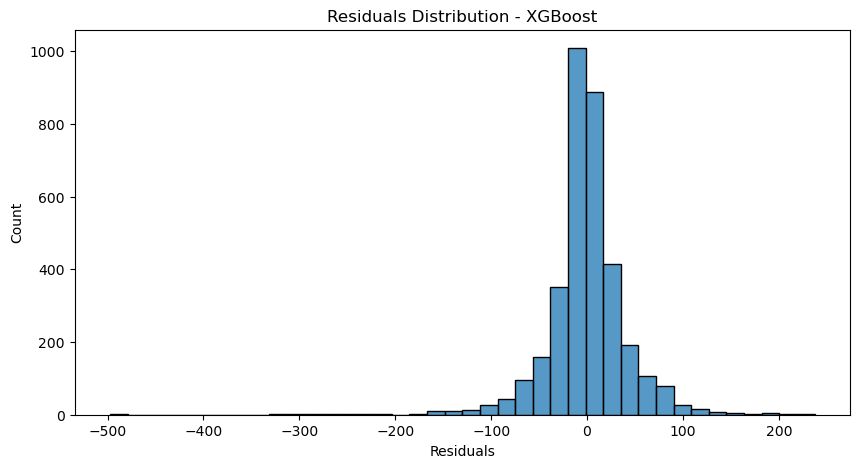

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

residuals_xgb = y_val - y_pred_xgb

plt.figure(figsize=(10, 5))
sns.histplot(residuals_xgb, bins=40)
plt.title("Residuals Distribution - XGBoost")
plt.xlabel("Residuals")
plt.show()

In [54]:
# Predict on training set
y_train_pred_xgb = xgb_model.predict(X_train)
r2_train_xgb = r2_score(y_train, y_train_pred_xgb)

print(f"Train R²: {r2_train_xgb:.4f}")
print(f"Val   R²: {r2_xgb:.4f}")

Train R²: 0.9643
Val   R²: 0.9465


#### Task 7: Hyperparameter Tuning

In [55]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define parameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Random Forest model
rf_base = RandomForestRegressor(random_state=42)

# Randomized Search with 5-fold CV
rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rf_param_grid,
    n_iter=25,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit
rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 50],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [56]:
print("Best Random Forest Parameters:")
print(rf_search.best_params_)

# Predict with best model
best_rf = rf_search.best_estimator_
y_val_rf_tuned = best_rf.predict(X_val)

# Evaluate
mse_rf_tuned = mean_squared_error(y_val, y_val_rf_tuned)
mae_rf_tuned = mean_absolute_error(y_val, y_val_rf_tuned)
r2_rf_tuned = r2_score(y_val, y_val_rf_tuned)

print(f"\nTuned Random Forest MSE: {mse_rf_tuned:.2f}")
print(f"Tuned Random Forest MAE: {mae_rf_tuned:.2f}")
print(f"Tuned Random Forest R² : {r2_rf_tuned:.4f}")

Best Random Forest Parameters:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 50}

Tuned Random Forest MSE: 1783.73
Tuned Random Forest MAE: 25.75
Tuned Random Forest R² : 0.9451


In [58]:
from skopt import BayesSearchCV
from xgboost import XGBRegressor
from skopt.space import Real, Integer

# Define parameter space
xgb_search_space = {
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'n_estimators': Integer(100, 500),
    'max_depth': Integer(3, 10),
    'subsample': Real(0.5, 1.0)
}

xgb = XGBRegressor(random_state=42)

xgb_bayes = BayesSearchCV(
    estimator=xgb,
    search_spaces=xgb_search_space,
    n_iter=25,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)

xgb_bayes.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
              scoring='neg_mean_squared_error',
              search_spaces={'learning_rate': Real(low=0.01, high=0.3, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=3, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=500, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')},
              verbose=2)

In [59]:
print("Best XGBoost Parameters:")
print(xgb_bayes.best_params_)

# Predict with best model
best_xgb = xgb_bayes.best_estimator_
y_val_xgb_tuned = best_xgb.predict(X_val)

# Evaluate
mse_xgb_tuned = mean_squared_error(y_val, y_val_xgb_tuned)
mae_xgb_tuned = mean_absolute_error(y_val, y_val_xgb_tuned)
r2_xgb_tuned = r2_score(y_val, y_val_xgb_tuned)

print(f"\nTuned XGBoost MSE: {mse_xgb_tuned:.2f}")
print(f"Tuned XGBoost MAE: {mae_xgb_tuned:.2f}")
print(f"Tuned XGBoost R² : {r2_xgb_tuned:.4f}")

Best XGBoost Parameters:
OrderedDict([('learning_rate', 0.04095346805067567), ('max_depth', 8), ('n_estimators', 445), ('subsample', 0.6153534566579657)])

Tuned XGBoost MSE: 1397.18
Tuned XGBoost MAE: 22.69
Tuned XGBoost R² : 0.9570


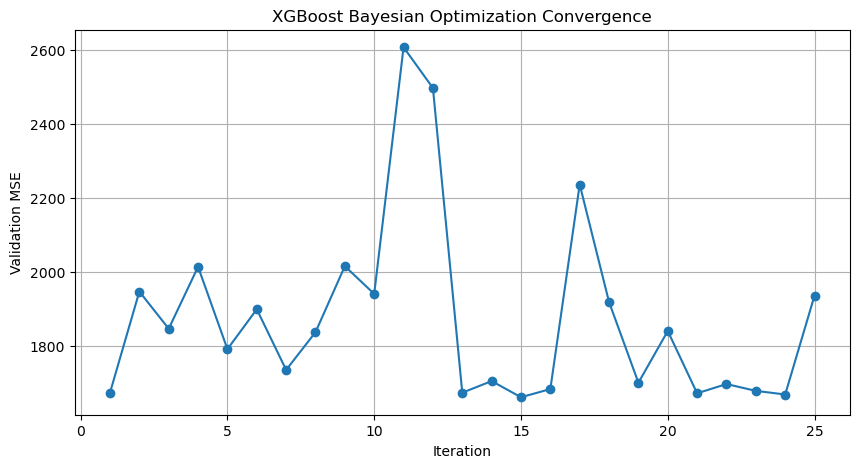

In [61]:
import matplotlib.pyplot as plt

# Get the best validation score per iteration (neg MSE, so we flip sign)
scores = -xgb_bayes.cv_results_['mean_test_score']

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(scores) + 1), scores, marker='o')
plt.title("XGBoost Bayesian Optimization Convergence")
plt.xlabel("Iteration")
plt.ylabel("Validation MSE")
plt.grid(True)
plt.show()

In [62]:
print("Best iteration:", np.argmin(scores) + 1)
print("Best MSE:", round(min(scores), 2))
print("Best parameters:", xgb_bayes.best_params_)

Best iteration: 15
Best MSE: 1661.77
Best parameters: OrderedDict([('learning_rate', 0.04095346805067567), ('max_depth', 8), ('n_estimators', 445), ('subsample', 0.6153534566579657)])


#### Task 8: Iterative Evaluation and Refinement

In [63]:
# Add interaction
X_train['temp_hum'] = X_train['temp'] * X_train['hum']
X_val['temp_hum'] = X_val['temp'] * X_val['hum']
X_test['temp_hum'] = X_test['temp'] * X_test['hum']

# Drop collinear feature
X_train.drop(columns='atemp', inplace=True)
X_val.drop(columns='atemp', inplace=True)
X_test.drop(columns='atemp', inplace=True)

# Retrain tuned XGBoost
xgb_refined = XGBRegressor(
    learning_rate=0.04095,
    max_depth=8,
    n_estimators=445,
    subsample=0.615,
    random_state=42
)
xgb_refined.fit(X_train, y_train)
y_val_refined = xgb_refined.predict(X_val)

# Evaluate
from sklearn.metrics import mean_squared_error, r2_score
print("Refined MSE:", mean_squared_error(y_val, y_val_refined))
print("Refined R² :", r2_score(y_val, y_val_refined))

Refined MSE: 1416.6973767948568
Refined R² : 0.9564096773892675


#### Task 9: Final Model Selection and Testing

In [64]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

# Combine training and validation sets
X_final_train = pd.concat([X_train, X_val])
y_final_train = pd.concat([y_train, y_val])

# Add interaction term
X_final_train['temp_hum'] = X_final_train['temp'] * X_final_train['hum']
X_test['temp_hum'] = X_test['temp'] * X_test['hum']

# Drop 'atemp' as done previously
X_final_train.drop(columns='atemp', inplace=True)
X_test.drop(columns='atemp', inplace=True)

# Retrain final model
final_model = XGBRegressor(
    learning_rate=0.04095,
    max_depth=8,
    n_estimators=445,
    subsample=0.615,
    random_state=42
)
final_model.fit(X_final_train, y_final_train)

KeyError: "['atemp'] not found in axis"